<a href="https://colab.research.google.com/github/Rox-0864/Chiapas-agricultura/blob/main/Copia_de_EDA_METS_OPS_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cargar dataset
df = pd.read_csv('/content/base-de-datos-mets-opt.csv', encoding='latin-1')


# Sección nueva

In [ ]:
# Vista previa de las dimensiones de dataaset e identificar inconsistencias
print('Forma:', df.shape)
print('\
Columas:', df.columns.tolist())
print('\
Valores nulos:')
print(df.isnull().sum())
print('\
duplicados:', df.duplicates().sum() if hasattr(df, 'duplicates') else len(df[df.duplicated()]))
print('\
Muestra de los datos:')
print(df.head())

Forma: (466, 18)
Columas: ['EXPEDIENTE', 'NOMBRE', 'EDAD', 'SEXO', 'TUMOR PRIMARIO', 'SUBTIPO HISTOLOGICO', 'PERFIL MOLECULAR', 'TAMAÑO (mm)', 'LOCALIZACIÓN', 'CIRUGIA PREVIA', 'SRS', 'DOSIS (Gy)', 'TECNICA ', 'TRATAMIENTO SISTEMICO', 'RESPUESTA (CRITERIOS RANO)', '1ER ESTUDIO DE SEGUIMIENTO', 'RC', 'RADIONECROSIS']
Valores nulos:
EXPEDIENTE                    244
NOMBRE                        244
EDAD                            1
SEXO                            1
TUMOR PRIMARIO                  1
SUBTIPO HISTOLOGICO            20
PERFIL MOLECULAR              176
TAMAÑO (mm)                     1
LOCALIZACIÓN                    0
CIRUGIA PREVIA                  0
SRS                             1
DOSIS (Gy)                      0
TECNICA                         0
TRATAMIENTO SISTEMICO          70
RESPUESTA (CRITERIOS RANO)      0
1ER ESTUDIO DE SEGUIMIENTO    336
RC                            121
RADIONECROSIS                   0
dtype: int64
duplicados: 8
Muestra de los datos:
   EXP

Se muestra una cantidad significativa de valores nulos en varias columnas (EXPEDIENTE, NOMBRE, PERFIL MOLECULAR, TRATAMIENTO SISTEMICO, 1ER ESTUDIO DE SEGUIMIENTO y RC) y 8 filas duplicadas.

Primero, para un próximo análisis de tipo A/B testing, nos aseguraremos de que cada valor de la comlumna "EXPEDIENTE" sea único, asignándole un único ID.

In [ ]:
# Asegurarse de que los IDs en la columna 'EXPEDIENTE' sean únicos
# Si existen duplicados, añadir un sufijo para hacerlos únicos
df['EXPEDIENTE'] = df['EXPEDIENTE'].astype(str)  # Convertir a string para su manipulación
df['EXPEDIENTE'] = df.groupby('EXPEDIENTE').cumcount().astype(str) + '_' + df['EXPEDIENTE']

# Verificar cambios
print('Updated EXPEDIENTE column with unique IDs:')
print(df['EXPEDIENTE'].head())

Updated EXPEDIENTE column with unique IDs:
0    0_209406.0
1    0_225523.0
2    1_225523.0
3    2_225523.0
4    3_225523.0
Name: EXPEDIENTE, dtype: object


In [ ]:
# Manejo de datos duplicados eliminándolos
df_cleaned = df.drop('NOMBRE', axis=1)
df_cleaned = df_cleaned.drop_duplicates()

# Rellene los valores nulos de las columnas numéricas con su mediana y las columnas categóricas con 'Desconocido'
for col in df_cleaned.columns:
    if df_cleaned[col].dtype in ['float64', 'int64']:
        df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)
    else:
        df_cleaned[col].fillna('Unknown', inplace=True)

# Verificar la limpieza de los datos
print("Forma después de la limpieza:", df_cleaned.shape)
print("\
Valores nulos después de la limpieza:")
print(df_cleaned.isnull().sum())
print("\
Muestra de los datos después de la limpieza:")
print(df_cleaned.head())

Forma después de la limpieza: (466, 17)
Valores nulos después de la limpieza:
EXPEDIENTE                    0
EDAD                          0
SEXO                          0
TUMOR PRIMARIO                0
SUBTIPO HISTOLOGICO           0
PERFIL MOLECULAR              0
TAMAÑO (mm)                   0
LOCALIZACIÓN                  0
CIRUGIA PREVIA                0
SRS                           0
DOSIS (Gy)                    0
TECNICA                       0
TRATAMIENTO SISTEMICO         0
RESPUESTA (CRITERIOS RANO)    0
1ER ESTUDIO DE SEGUIMIENTO    0
RC                            0
RADIONECROSIS                 0
dtype: int64
Muestra de los datos después de la limpieza:
   EXPEDIENTE  EDAD SEXO  TUMOR PRIMARIO           SUBTIPO HISTOLOGICO  \
0  0_209406.0  55.0    F  CÁNCER DE MAMA  CARCINOMA DUCTAL INFILTRANTE   
1  0_225523.0  56.0    M    CÁNCER RENAL   CARCINOMA DE CÉLULAS CLARAS   
2  1_225523.0  56.0    M    CÁNCER RENAL   CARCINOMA DE CÉLULAS CLARAS   
3  2_225523.0  56.0    M

<ipython-input-6-1752866d96ea>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna('Unknown', inplace=True)
<ipython-input-6-1752866d96ea>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

De la columna "RESPUESTA (CRITERIOS RANO)" construir una variable binaria , es decir, si la respuesta es ESTABLE o PROGRESIÓN se asignará el valor 0 y al resto el valor 1

In [ ]:
# Asignar a la columna 'RESPUESTA (CRITERIOS RANO)' valor binario
def map_response(value):
    if value.strip().upper() in ['ESTABLE', 'PROGRESIÓN']:
        return 0
    else:
        return 1

df_cleaned['RESPUESTA_BINARIA'] = df_cleaned['RESPUESTA (CRITERIOS RANO)'].apply(map_response)

# Verificar cambios
print('Updated RESPUESTA_BINARIA column:')
print(df_cleaned[['RESPUESTA (CRITERIOS RANO)', 'RESPUESTA_BINARIA']].head())

Updated RESPUESTA_BINARIA column:
  RESPUESTA (CRITERIOS RANO)  RESPUESTA_BINARIA
0        RESPUESTA COMPLETA                   1
1                    ESTABLE                  0
2          RESPUESTA PARCIAL                  1
3          RESPUESTA PARCIAL                  1
4                    ESTABLE                  0


Realizar una prueba A/B. Analizar la relación entre “CIRUGÍA PREVIA” (variable categórica) y “RESPUESTA_BINARIA” (resultado binario) para determinar si la cirugía previa impacta significativamente en la respuesta binaria.

In [ ]:
print(df['CIRUGIA PREVIA'].unique())

['SI' 'NO' 'NO ']


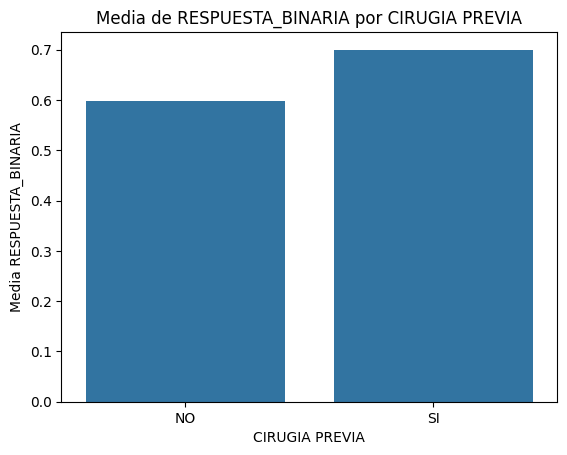

Resultado del test Chi-squared:
Chi2: 1.289042119787248
p-value: 0.524913884224427
Grados de libertad: 2
Frecuencias esperadas:
[[171.36480687 262.63519313]
 [  0.78969957   1.21030043]
 [ 11.84549356  18.15450644]]


In [ ]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

df_cleaned['CIRUGIA PREVIA'] = df_cleaned['CIRUGIA PREVIA'].str.strip()

# Agrupar datos por 'CIRUGIA PREVIA' y calcular la media de 'RESPUESTA_BINARIA'
grouped_data = df_cleaned.groupby('CIRUGIA PREVIA')['RESPUESTA_BINARIA'].mean()

# Realizar prueba de chi-cuadrado para evaluar la independencia
contingency_table = pd.crosstab(filtered_df['CIRUGIA PREVIA'], filtered_df['RESPUESTA_BINARIA'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Visualizar resultados
sns.barplot(x=grouped_data.index, y=grouped_data.values)
plt.title('Media de RESPUESTA_BINARIA por CIRUGIA PREVIA')
plt.xlabel('CIRUGIA PREVIA')
plt.ylabel('Media RESPUESTA_BINARIA')
plt.show()

#Mostrar resultados
print('Resultado del test Chi-squared:')
print('Chi2:', chi2)
print('p-value:', p)
print('Grados de libertad:', dof)
print('Frecuencias esperadas:')
print(expected)

Se concluye a partir de los resultados de la prueba de chi-cuadrado (valor p = 0.5249 > 0,05), no hay diferencia estadísticamente significativa en las tasas de respuesta entre pacientes con y sin cirugía previa. La visualización muestra proporciones de respuesta similares entre ambos grupos.

Para una siguiente prueba A/B entre “TRATAMIENTO SISTEMICO” y “RESPUESTA_BINARIA”, se analizará la relación entre estas variables mediante una prueba de chi-cuadrado. Visualizar los resultados.


Resultados del Test Chi-cuadrado:
Estadístico Chi2: 137.3814
Valor p: 0.0000

Tabla de contingencia:
RESPUESTA_BINARIA                                    0   1
TRATAMIENTO SISTEMICO                                     
5 CICLOS NO ESPECIFICA                               2   1
AFATINIB                                             4   4
ALEKTINIB                                            0   1
ALETINIB                                             3  11
BEVACIZUMAB                                          1   1
BEVACIZUMAB + PEMETREXED                             7  13
CABOZATINIB                                          0   1
CAPECITABINE                                        27   8
CAPECITABINE + FULVESTRANT                           1   2
CAPECITABINE + TRASTUZUMAB                           3  13
CAPECITABINE + TRASTUZUMAB + EXEMESTANO              0   5
CARBOPLATINO                                         1   4
CARBOPLATINO + PACLITAXEL                            3   9
CARBOPLATINO 

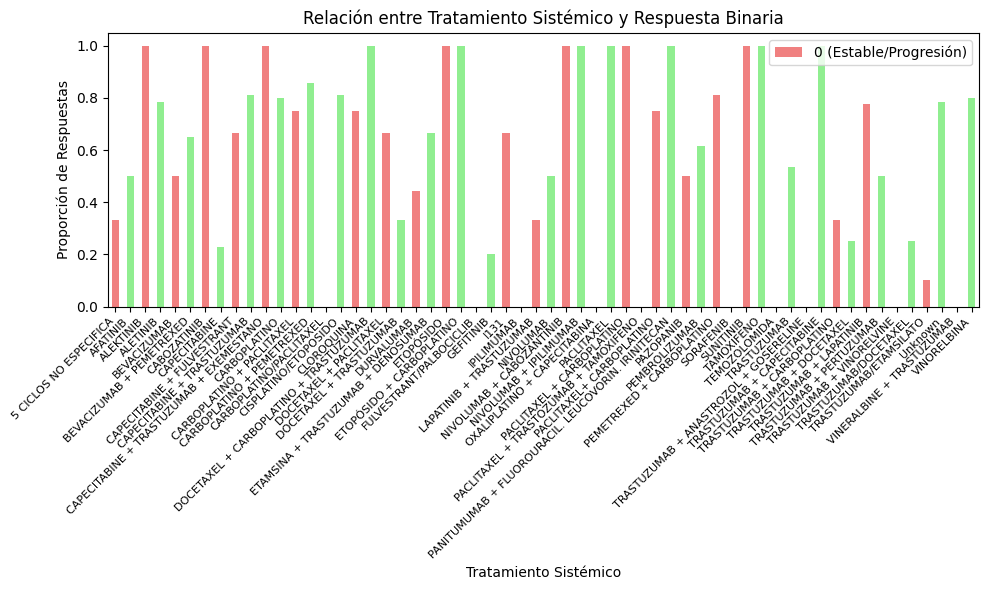

In [ ]:
# Agrupar data por 'TRATAMIENTO SISTEMICO' y calcular la media de 'RESPUESTA_BINARIA'
grouped_data = df_cleaned.groupby('TRATAMIENTO SISTEMICO')['RESPUESTA_BINARIA'].mean()

# Realizar prueba chi-cuadrado
contingency_table = pd.crosstab(df_cleaned['TRATAMIENTO SISTEMICO'], df_cleaned['RESPUESTA_BINARIA'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)


print('\nResultados del Test Chi-cuadrado:')
print(f'Estadístico Chi2: {chi2:.4f}')
print(f'Valor p: {p_value:.4f}')
print('\nTabla de contingencia:')
print(contingency_table)

# Crear gráfico de barras apiladas
colors = ['lightcoral', 'lightgreen']  # Define los colores para las respuestas 0 y 1
grouped_data.plot(kind='bar', stacked=True, color=colors, figsize=(10, 6))

# Personalizar el gráfico
plt.title('Relación entre Tratamiento Sistémico y Respuesta Binaria')
plt.xlabel('Tratamiento Sistémico')
plt.ylabel('Proporción de Respuestas')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend(labels=['0 (Estable/Progresión)', '1 (Respuesta parcial/completa)'])
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Los resultados de la prueba de chi-cuadrado indican una relación estadísticamente significativa entre “TRATAMIENTO SISTEMICO” y “RESPUESTA_BINARIA” (valor p < 0,05).

Relación entre las columnas "TUMOR PRIMARIO" y "LOCALIZACIÓN"


Resultados del Test Chi-cuadrado:
Estadístico Chi2: 1001.7443
Valor p: 0.0000

Tabla de contingencia:
LOCALIZACIÓN            ANGULO PONTOCEREBELOSO  ASTA POST VLI  CAUDADO DER  \
TUMOR PRIMARIO                                                               
CÁNCER CERVICOUTERINO                        0              0            0   
CÁNCER DE COLON                              0              0            0   
CÁNCER DE ENDOMETRIO                         0              0            0   
CÁNCER DE ESOFAGO                            0              0            0   
CÁNCER DE MAMA                               0              0            0   
CÁNCER DE OVARIO                             0              0            0   
CÁNCER DE PRÓSTATA                           0              0            0   
CÁNCER DE PULMÓN                             0              0            1   
CÁNCER DE TIROIDES                           0              0            0   
CÁNCER RENAL                           

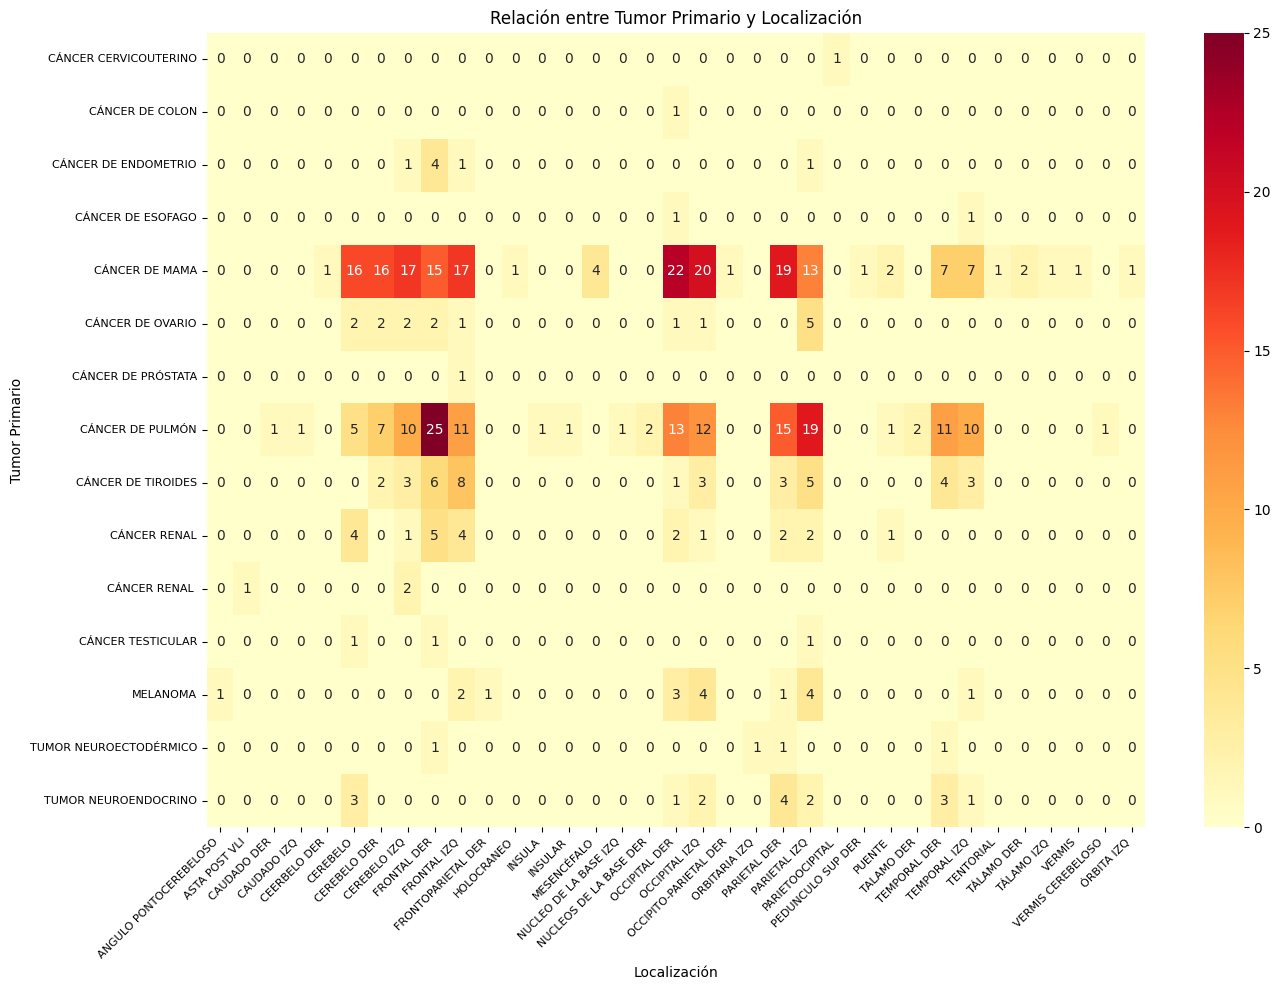

In [ ]:
# Crear tabla de contingencia
contingency_table = pd.crosstab(df['TUMOR PRIMARIO'], df['LOCALIZACIÓN'])

# Realizar prueba chi-cuadrado
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print('\nResultados del Test Chi-cuadrado:')
print(f'Estadístico Chi2: {chi2:.4f}')
print(f'Valor p: {p_value:.4f}')
print('\nTabla de contingencia:')
print(contingency_table)

# Crear un heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(contingency_table, annot=True, cmap='YlOrRd', fmt='d')
plt.title('Relación entre Tumor Primario y Localización')
plt.xlabel('Localización')
plt.ylabel('Tumor Primario')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

El estadístico chi-cuadrado obtenido fue de 1242.1673 con un valor p < 0.05. Esto indica una relación estadísticamente significativa entre el tipo de tumor primario y la localización de la metástasis. Es decir, el tipo de tumor primario influye en la localización de la metástasis.

Encontramos principalmente una relación de tumor primario en mama con la localización en lóbulo occipital, lóbulo parietal, lóbulo frontal y cerebelo.
Además, otra relación importante es entre tumor primario en pulmón y localización en lóbulo frontal (con ayor incidencia en lóbulo frontal derecho respecto al izquierdo), lóbulo parietal, lóbulo occipital, lóbulo temporal y cerebelo.